In [1]:
import os
import shutil
import zipfile
import urllib.request
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dirpath = '/content/drive/MyDrive/MindX_Data/Optical Imaging System Data Sets/'
fpath = 'offaxis_10_27_2020/tf'

In [3]:
import tensorflow as tf
from pathlib import Path

def load_dataset(path):
    return (tf.data.Dataset.list_files(str(Path(path) / '*'), shuffle=False)
        # Note: cycle_length=1 ensures that sessions are loaded sequentially.
        # If sessions can be intermingled, then cycle_length can be increased for better performance.
        .interleave(_load_session, cycle_length=1, num_parallel_calls=tf.data.AUTOTUNE)
    )

@tf.function
def _load_session(path):
    return tf.data.experimental.load(
        path,
        dict(
            data=tf.TensorSpec((None, None), dtype=tf.float32),
            time=tf.TensorSpec((), dtype=tf.float64),
            stimulus=tf.TensorSpec((), dtype=tf.bool),
            dataset=tf.TensorSpec((), dtype=tf.string),
            ekg=tf.TensorSpec((), dtype=tf.float32),
            ppg=tf.TensorSpec((), dtype=tf.float32),
        ),
    )

ds = load_dataset(dirpath + fpath)
ds

<ParallelInterleaveDataset shapes: {data: (None, None), time: (), stimulus: (), dataset: (), ekg: (), ppg: ()}, types: {data: tf.float32, time: tf.float64, stimulus: tf.bool, dataset: tf.string, ekg: tf.float32, ppg: tf.float32}>

In [4]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from scipy import signal
# from IPython.display import clear_output
import pickle
import os

In [5]:
from zipfile import ZipFile

if os.path.exists('hyppo-master'):
    print('HYPPO ALREADY INSTALLED')
else:
    try:
        with ZipFile('hyppo-master.zip', 'r') as zipObj:
            # Extract all the contents of zip file in current directory
            zipObj.extractall()

        # % git clone https://github.com/neurodata/hyppo
        %cd hyppo-master
        %pip install .
        %cd ..
    except:
        print('ZIP FILE DOES NOT EXIST')

HYPPO ALREADY INSTALLED


In [6]:
# %pip install hyppo # does not have KMERF yet
import hyppo

In [7]:
def compute_ROI(ds1):

    origin = [0.5, 0.5]
    radius = 0.3
    holograms = tf.convert_to_tensor(ds1, tf.float32)
    shape = [64, 64]#tf.shape(holograms)[1:]

    x, y = tf.meshgrid(
        tf.linspace(0. - origin[0], 1. - origin[0], shape[0]),
        tf.linspace(0. - origin[1], 1. - origin[1], shape[1]),
    )
    grid = tf.sqrt(x**2 + y**2)
    mask = grid <= radius

    region = tf.boolean_mask(holograms, mask, axis=0)
    mean = tf.math.reduce_mean(region, axis=-1)

    return mean, mask

In [8]:
filename = 'ds.pickle'

if os.path.exists(filename):
    with open(filename, 'rb') as f:
        ds1 = pickle.load(f, encoding='bytes')
else:
    ds1 = [[],[],[],[],[],[],[]]

    for idx, data in enumerate(tqdm(ds)):
        # if data['dataset'] == bytes(b'AQ'):
        temp = data['data'].numpy()
        # ds1[0].append(temp)
        ds1[1].append(data['time'].numpy())
        ds1[2].append(data['stimulus'].numpy())
        ds1[3].append(data['dataset'].numpy())
        ds1[4].append(data['ekg'].numpy())
        ds1[5].append(data['ppg'].numpy())
        roi, _ = compute_ROI(temp) # compute ROI for all range
        ds1[6].append(roi.numpy())

    with open(filename, 'wb') as f:
        pickle.dump(ds1, f)

In [9]:
# data, time, stimulus, dataset, ekg, ppg

In [10]:
for data in ds:
    mean, mask = compute_ROI(data['data'].numpy())
    sample_data = data['data'].numpy()
    break

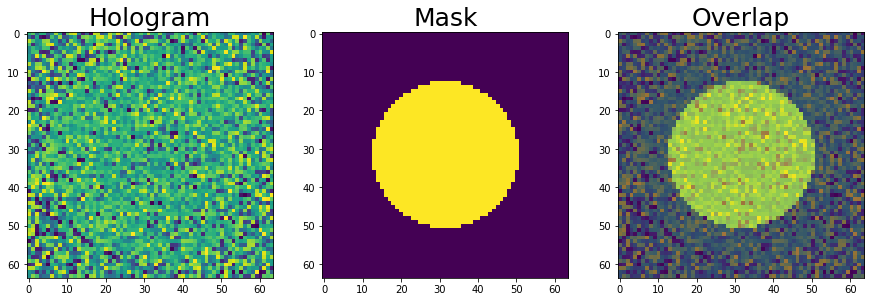

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.imshow(sample_data)
ax2.imshow(mask)

ax3.imshow(sample_data)
ax3.imshow(mask, alpha=0.5)

labels = ['Hologram', 'Mask', 'Overlap']

for i, lab in enumerate((ax1,ax2,ax3)):
    lab.set_title(labels[i], fontsize=25)

fig.savefig('hologram_mask.png', bbox_inches='tight')

In [12]:
ds1 = np.array(ds1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [13]:
for i in ds1:
    try: print(i[0])
    except: print([])

[]
0.000227
False
b'AQ'
-0.020156119
-0.17671353
95.45412


In [14]:
# only one dataset type
set(ds1[3])

{b'AQ', b'AR', b'AS', b'AT', b'AU', b'AV', b'AW', b'AX', b'AY', b'AZ'}

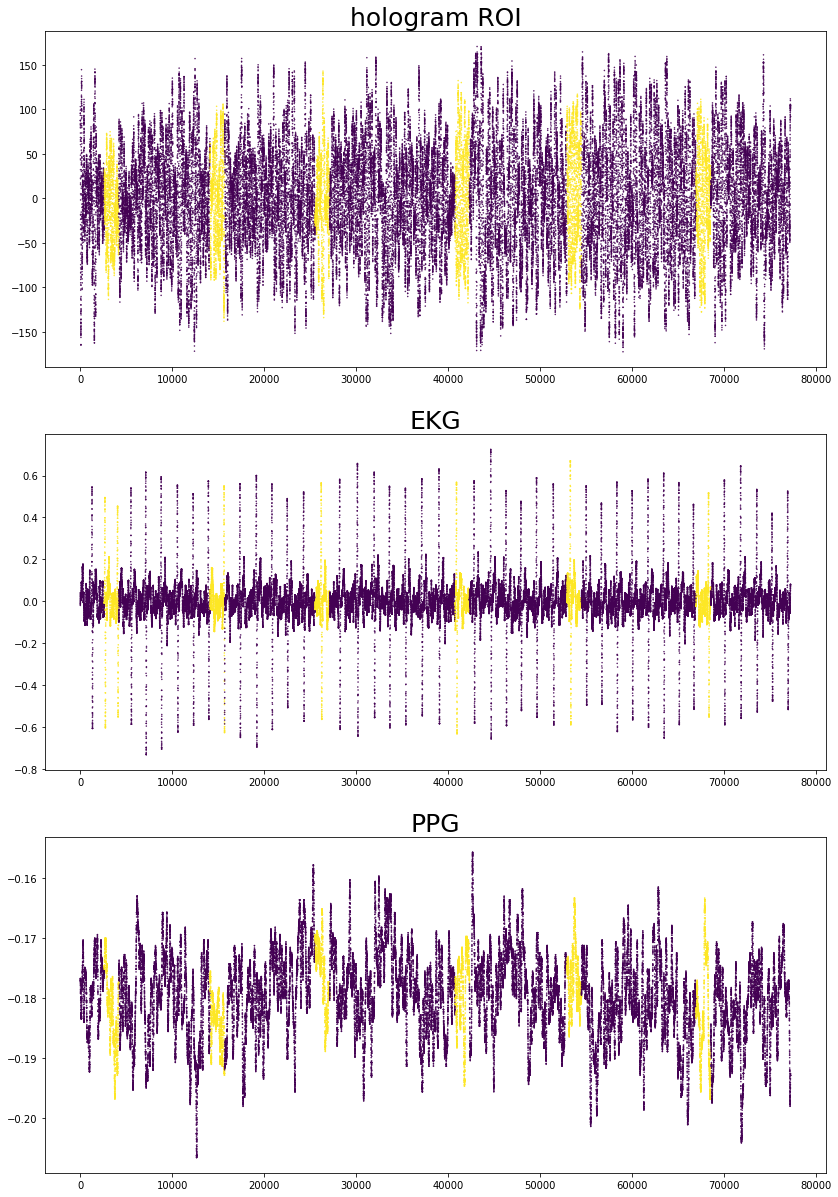

In [15]:
aq = np.array(ds1[3]) == bytes(b'AQ')

t_i = np.arange(0,np.array(ds1[1])[aq].size)
t = np.array(ds1[2])[aq]+0

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(14,7*3))

ax1.scatter(t_i, np.array(ds1[6])[aq], ls='-', marker='.', s=1, c=t)
ax2.scatter(t_i, np.array(ds1[4])[aq], ls='-', marker='.', s=1, c=t)
ax3.scatter(t_i, np.array(ds1[5])[aq], ls='-', marker='.', s=1, c=t)

labels = ['hologram ROI', 'EKG', 'PPG']

for i, lab in enumerate((ax1,ax2,ax3)):
    lab.set_title(labels[i], fontsize=25)

fig.savefig('data_visualization.png', bbox_inches='tight')

In [17]:
new_ds = np.array([])
new_ds = [[] for i in range(7)]

for i, dat in enumerate(ds1):
    new_ds[i] = np.array(dat)

In [18]:
# binarize boolean
new_ds[2] = new_ds[2] + 0
new_ds[2]

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
# data, time, stimulus, dataset, ekg, ppg
ds_by_session = [[] for i in range(10)]

for i, b_id in enumerate(set(new_ds[3])):
    idx = new_ds[3] == b_id
    ds_by_session[i].append(new_ds[1][idx]) #time
    ds_by_session[i].append(new_ds[2][idx]) #stimulus
    ds_by_session[i].append(np.array([new_ds[6][idx], new_ds[4][idx], new_ds[5][idx]]).T) #ekg, ppg, hologram ROI

In [20]:
def check_discontinuity(data):
    '''input is a list of 0 and 1'''
    new_list = [[], []]
    temp = []
    for i in range(len(data)-1):
        temp.append(i)
        if data[i] != data[i+1]:
            new_list[data[i]].append(temp)
            temp = []
    if len(temp) != 0:
        new_list[data[temp[0]]].append(temp)
    return new_list

In [21]:
# makes separate lists of baseline (0) and stimulus (1)
ds_two_sample = [[] for i in range(10)]

for ii, dat in enumerate(ds_by_session):
    temp_idx = check_discontinuity(dat[1])
    ds_two_sample[ii].append([]) 
    ds_two_sample[ii].append([]) 
    try:
        for i in range(6):
            ds_two_sample[ii][0].append(dat[2][temp_idx[0][i+1]]) #skips the first baseline segment
            ds_two_sample[ii][1].append(dat[2][temp_idx[1][i]])
    except:
        print('Index out of bound: there are more than 6 stimulations')

In [22]:
# resampling to average baseline length
ds_two_sample_resampled = ds_two_sample.copy()

for ii, dat in enumerate(ds_two_sample_resampled):
    avg = 0
    for i in range(6):
        avg += dat[0][i].shape[0] #assumes baseline to be longer
    avg = avg // 6

    for i in range(6):
        ds_two_sample_resampled[ii][0][i] = signal.resample(dat[0][i], avg)
        ds_two_sample_resampled[ii][1][i] = signal.resample(dat[1][i], avg)

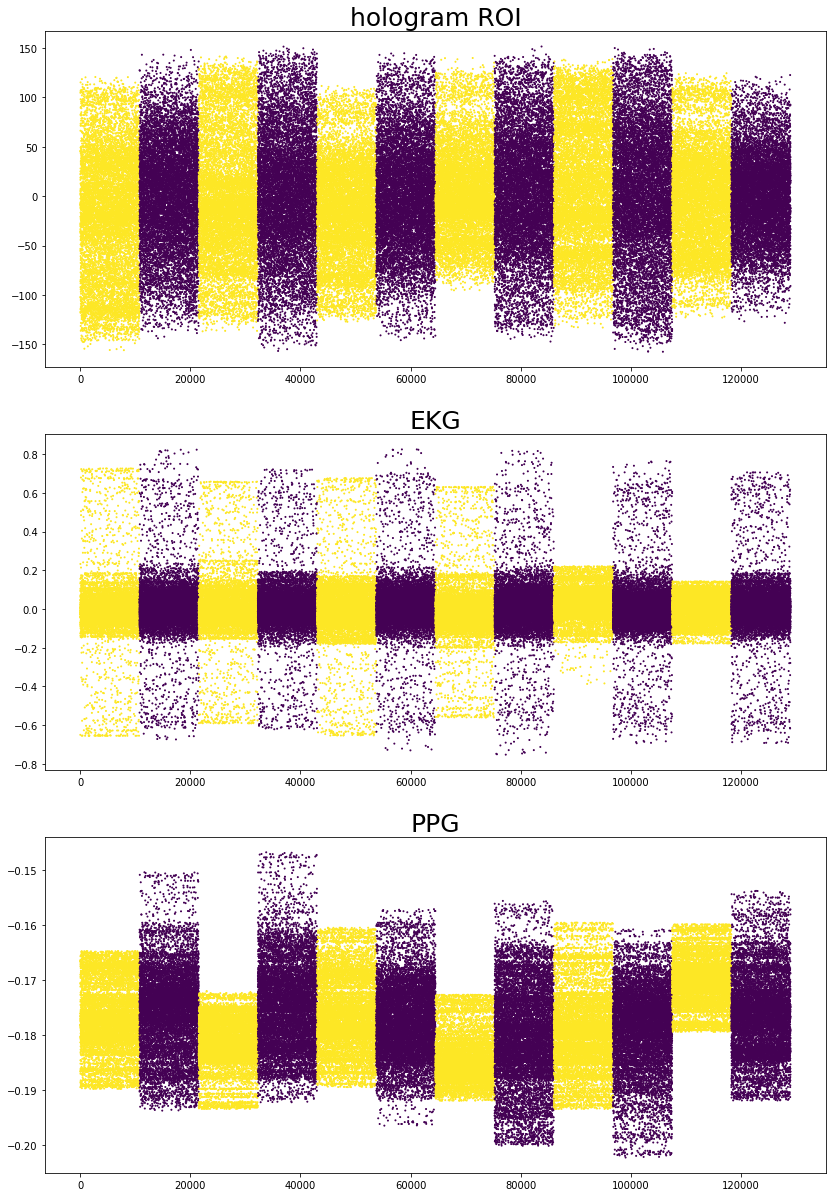

In [23]:
# plot concatenated resampled signal
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(14,7*3))

labels = ['hologram ROI', 'EKG', 'PPG']
rnd = True #pre-registering

for k, ax in enumerate((ax1,ax2,ax3)):

    temp_array = np.array([])
    temp_idx = []

    for i in range(6):    
        for j in [1,0]:
            if rnd:
                temp_array2 = ds_two_sample_resampled[0][j][i][:,k].copy()
                np.random.shuffle(temp_array2)
                temp_array = np.append(temp_array,temp_array2)
            else:
                temp_array = np.append(temp_array,ds_two_sample_resampled[0][j][i][:,k])
            size = ds_two_sample_resampled[0][j][i][:,k].size
            temp_idx += [j]*size

    x_i = np.arange(0,len(temp_idx))
    ax.scatter(x_i, temp_array, c=temp_idx, s=1)
    ax.set_title(labels[k], fontsize=25)

if rnd:
    fig.savefig('data_visualization_resampled_preregistered.png', bbox_inches='tight')
else:
    fig.savefig('data_visualization_resampled.png', bbox_inches='tight')